In [17]:
using Pkg
Pkg.activate(".")

  Activating project at `d:\Math\PhD\research\summer2025\tau-leaping-practice`


In [18]:
using Catalyst, Plots, Distributions
include("ssa2.jl")
include("get_value_at.jl")

get_value_at (generic function with 1 method)

This is the file to compare my SSA code with Catalyst for the process  
$ A + B \leftrightarrow C $ with rate $k_1 ,k_2$.  
$A \leftrightarrow \emptyset$ with rate $k_3, k_4$.  
$B \leftrightarrow \emptyset$ with rate $k_5, k_6$.  
First, we introduce the initial state of $A,B,C$. Then, we simulate the process using my SSA and Catalyst's SSA. Then we calculate the analytic error and plot the log-log. Finally, we calculate the slope of the linear approximation to check if it is close to $\dfrac{1}{2}$.

In [19]:
# Initial condition
A0 = 100
B0 = 100
C0 = 0
# Rate constant
k1 = 2.0 
k2 = 1.0
k3 = 0.5
k4 = 1.0
k5 = 0.5
k6 = 1.0
T = 5.0 # Final time to stop simulation
times = 0:0.0001:T

0.0:0.0001:5.0

In [20]:
# Define the process using Catalyst
process = @reaction_network begin
    (r1, r2), A + B <--> C
    (r3, r4), A <--> ∅
    (r5, r6), B <--> ∅
end

para = (:r1 => k1, :r2 => k2,
    :r3 => k3, :r4 => k4,
    :r5 => k5, :r6 => k6
    )
tspan = (0,T)
init = Dict(:A => A0, :B => B0, :C => C0)
jinput = JumpInputs(process, init, tspan, para)
jprob = JumpProblem(jinput; save_positions = (false, false)) #this means that only return the first time [0.0,T] and first and last position


JumpProblem with problem DiscreteProblem with aggregator JumpProcesses.Direct
Number of jumps with discrete aggregation: 0
Number of jumps with continuous aggregation: 0
Number of mass action jumps: 6


In [21]:
simulations = 100:100:2000
# Define the errors
errA = zeros(length(simulations))
errB = zeros(length(simulations))
errC = zeros(length(simulations))
for i in eachindex(simulations)
    Acat_temp = zeros(length(times))
    Bcat_temp = zeros(length(times))
    Ccat_temp = zeros(length(times))
    for j in 1:simulations[i]
        sol = solve(jprob; saveat = times) #save at desired times, used with save_positions
        Acat_temp .+= sol[process.A]
        Bcat_temp .+= sol[process.B] 
        Ccat_temp .+= sol[process.C]  
    end
    Acat_temp ./= simulations[i]
    Bcat_temp ./= simulations[i]
    Ccat_temp ./= simulations[i]

    Assa_temp = zeros(length(times))
    Bssa_temp = zeros(length(times))
    Cssa_temp = zeros(length(times))
    sim_ssa = [ssa2(A0,B0,C0,k1,k2,k3,k4,k5,k6,T) for l in 1:simulations[i]]
    for j in eachindex(sim_ssa)
        Atempssa = get_value_at(sim_ssa[j][1], sim_ssa[j][2], times)
        Assa_temp .+= Atempssa # dot means upadting in a loop
        Btempssa = get_value_at(sim_ssa[j][1], sim_ssa[j][3], times)
        Bssa_temp .+= Btempssa  
        Ctempssa = get_value_at(sim_ssa[j][1], sim_ssa[j][4], times)
        Cssa_temp .+= Ctempssa 
    end
    Assa_temp ./= simulations[i]
    Bssa_temp ./= simulations[i]
    Cssa_temp ./= simulations[i]

    errorA = maximum(abs.(Assa_temp - Acat_temp))
    errorB = maximum(abs.(Bssa_temp - Bcat_temp))
    errorC = maximum(abs.(Cssa_temp - Ccat_temp))
    errA[i] = errorA
    errB[i] = errorB
    errC[i] = errorC
end

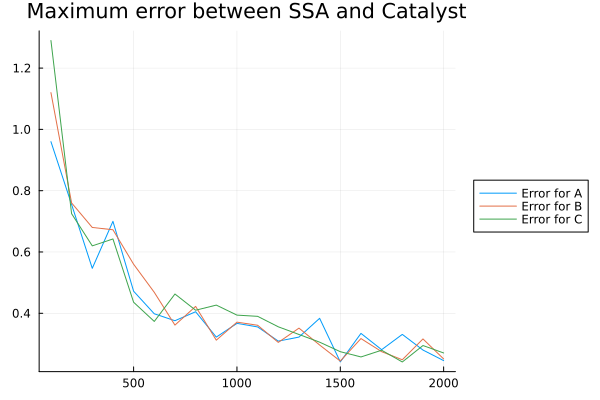

In [22]:
pic1 = plot(simulations, errA,
    title = "Maximum error between SSA and Catalyst",
    label = "Error for A", legend = :outerright
)
plot!(simulations, errB, label = "Error for B")
plot!(simulations, errC, label = "Error for C")

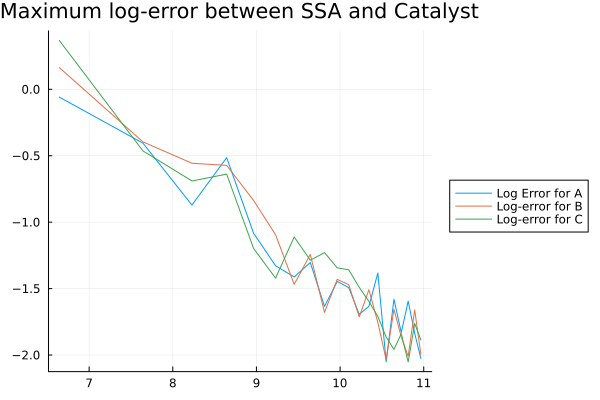

In [23]:
# Check convergence using log-log 
x = log2.(simulations)
yA = log2.(errA)
yB = log2.(errB)
yC = log2.(errC)
pic2 = plot(x, yA,
    title = "Maximum log-error between SSA and Catalyst",
    label = "Log Error for A", legend = :outerright
)
plot!(x, yB, label = "Log-error for B")
plot!(x, yC, label = "Log-error for C")

In [24]:
# Estimate the slope of the linear approximation
A = [ones(length(x)) x]
(interceptA, slopeA) = A \ yA 
(interceptB, slopeB) = A \ yB
(interceptB, slopeC) = A \ yC
slopeA = abs(slopeA)
slopeB = abs(slopeB)
slopeC = abs(slopeC)

println("Estimated slope for error of A: $slopeA")
println("Estimated slope for error of B: $slopeB")
println("Estimated slope for error of C: $slopeC")


Estimated slope for error of A: 0.4283954750629607
Estimated slope for error of B: 0.5006024475301699
Estimated slope for error of C: 0.493605223297697
